In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

In [1]:
import torch
from monai.data import (
    DataLoader,
    ImageDataset,
    decollate_batch
)
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    ToTensord,
    Spacing,
    EnsureType,
    LoadImage,
    Resize,
    AddChannel,
    NormalizeIntensity
)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Load in model that segments Brain Tumour Core"
model = torch.load('brainTumor96_96_48.pth')
model.eval()

SegResNet(
  (act): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affi

In [3]:
#Required transformations using MONAI
val_transforms = Compose( #Transformations for training dataset
    [
        Spacing(pixdim=(
            1.0, 1.0, 1.0), mode=("nearest")),
        AddChannel(),
        Resize((96,96,48)),
        NormalizeIntensity(),
        AddChannel(),
        EnsureType()
    ]
)

In [4]:
#Sample Images to load
TC_images = [["BrainTumourNift/BRATS_487.nii.gz"], ["BrainTumourNift/BRATS_488.nii.gz"], ["BrainTumourNift/BRATS_489.nii.gz"]]

In [5]:
#Adding to image dataset
TC_ds = ImageDataset(TC_images[0], transform=val_transforms, ImageOnly=True)

In [6]:
TC_ds[0][0].shape

torch.Size([1, 1, 96, 96, 48])

In [7]:
#Get output from model
output = model(TC_ds[0][0])

In [8]:
#Get two classes from model: Tumor and Non-Tumor
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
output_TC = [post_pred(i) for i in decollate_batch(output)]

In [9]:
#Find slice with largest number of voxels positive for tumor
slice_sum_g = 0
sliceval=24
for i in range(len(output_TC[0][0][0,0,:])):
    slice_sum = output_TC[0].numpy()[1][:,:,i].sum()
    if slice_sum > slice_sum_g:
        slice_sum_g = slice_sum
        sliceval = i
print("Slice Value Tumor Found: ", sliceval)

Slice Value Tumor Found:  25


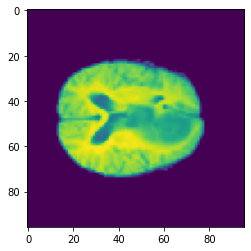

In [10]:
plt.imshow(TC_ds[0][0].numpy()[0][0][:,:,sliceval])

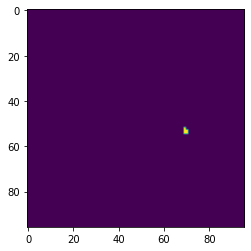

In [11]:
plt.imshow(output_TC[0].numpy()[1][:,:,sliceval])

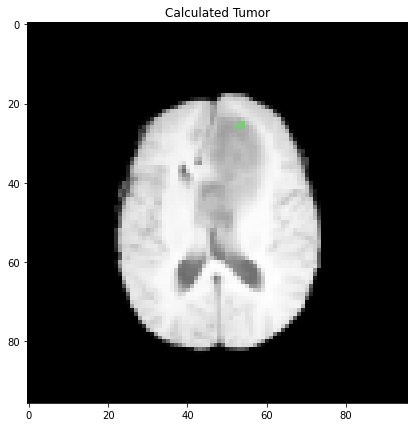

In [15]:
maskedTum = np.ma.masked_where(output_TC[0].numpy()[1][:,:,sliceval] == 0, output_TC[0].numpy()[1][:,:,sliceval])
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Calculated Tumor')
plt.imshow(np.rot90(TC_ds[0][0].numpy()[0][0][:,:,sliceval]), cmap='Greys_r')
plt.imshow(np.rot90(maskedTum), cmap='Accent', alpha=1.0)
plt.savefig('Img969648.png')